# Applying some basic machine learning to the culled dataset of amino acid distances and antigenic distances


In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import linear_model as sklm
from sklearn import svm
from sklearn import ensemble
from sklearn import grid_search
import plotly.plotly as py
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.patches as mpatches
np.set_printoptions(suppress=True) 

Populating the interactive namespace from numpy and matplotlib


### A function to create new columns containing the full dates of both strains 
Add columns to data frame with strain dates separated into their components. Adjust years from 2-digit strings to integers that include the century.

In [2]:
 def separate_dates(df, strain1ColHeading, strain2ColHeading):
        """
        Add columns to data frame with strain dates separated into their
        components. Adjust years from 2-digit strings to integers that
        include the century.

        @param strain1ColHeading: The C{str} strain1 label column heading in self.df.
        @param strain2ColHeading: The C{str} strain2 label column heading in self.df.
        """
        strain_1_labels = list(df[strain1ColHeading])
        strain_2_labels = list(df[strain2ColHeading])

        strain_1_dates = []
        strain_2_dates = []

        for label in strain_1_labels:
            date = int(list(label.split('/'))[-1])
            if date < 60:
                date += 2000
            else:
                date += 1900
            strain_1_dates.append(date)

        for label2 in strain_2_labels:
            date = int(list(label2.split('/'))[-1])
            if date < 60:
                date += 2000
            else:
                date += 1900
            strain_2_dates.append(date)

        df['strain_1_dates'] = pd.Series(strain_1_dates,
                                              index=df.index)
        df['strain_2_dates'] = pd.Series(strain_2_dates,
                                              index=df.index)

    

### A function to add a column with strain 1 and 2 clusters
Clusters defined based on the map here: http://www.antigenic-cartography.org/ 

In [3]:
 def add_clusters(df):
        """
        Add columns that contain cluster labels, based on the 
        clusters in the map here http://www.antigenic-cartography.org/
        """
        strain_1_cluster = []
        strain_2_cluster = []

        for date in df['strain_1_dates']:
            if date < 1972:
                strain_1_cluster.append('HK68')
            elif date < 1975:
                    strain_1_cluster.append('EN72')
            elif date < 1977:
                    strain_1_cluster.append('VI75')
            elif date < 1979:
                    strain_1_cluster.append('TX77')
            elif date < 1987:
                    strain_1_cluster.append('BK79')
            elif date < 1989:
                    strain_1_cluster.append('SI87')
            elif date < 1992:
                    strain_1_cluster.append('BE89')
            elif date < 1995:
                    strain_1_cluster.append('BE92')
            elif date < 1997:
                    strain_1_cluster.append('WU95')
            elif date < 2002:
                    strain_1_cluster.append('SY97')
            else:
                    strain_1_cluster.append('FU02')

        for date in df['strain_1_dates']:
            if date < 1972:
                strain_2_cluster.append('HK68')
            elif date < 1975:
                    strain_2_cluster.append('EN72')
            elif date < 1977:
                    strain_2_cluster.append('VI75')
            elif date < 1979:
                    strain_2_cluster.append('TX77')
            elif date < 1987:
                    strain_2_cluster.append('BK79')
            elif date < 1989:
                    strain_2_cluster.append('SI87')
            elif date < 1992:
                    strain_2_cluster.append('BE89')
            elif date < 1995:
                    strain_2_cluster.append('BE92')
            elif date < 1997:
                    strain_2_cluster.append('WU95')
            elif date < 2002:
                    strain_2_cluster.append('SY97')
            else:
                    strain_2_cluster.append('FU02')

        df['strain_1_cluster'] = pd.Series(strain_1_cluster, index=df.index)
        df['strain_2_cluster'] = pd.Series(strain_2_cluster, index=df.index)

### A function to create a cross validation set
The training set consists of all pairs where neither strain is a member of a particular cluster. 
The test set consists of all pairs where at least one strain is a member of that cluster

In [4]:
    def cv(df, strain_1_labels, strain_2_labels):
        """
        Create a cross validation set.

        The training sets consists of all pairs where neither strain is a
        member of a particular cluster. The test sets consists of all pairs
        where at least one strain is a member of that cluster

        @params: headings of the columns which contain the labels (e.g. cluster names) that
        you want to split the data on

        @return: A cross-validation object, which is a list of train-test tuples 
        which contain the indices of the rows of the dataframe to be used in the 
        training and test data. This can be passed to scikit-learn's cross validation
        methods
        """
        return [(np.where(
            (df[strain_1_labels] != label) & (df[strain_2_labels] != label))[0],
               np.where((df[strain_1_labels] == label) & (df[strain_2_labels] == label))[0])
              for label in np.unique(df[strain_1_labels])]


Open the file, add columns for the dates and cluster, and check the shape

In [5]:
file = open('35yr-culled-1-20-to-25.csv')
df = pd.read_csv(file)
#df = df.drop(0)
#df = df.drop('Unnamed: 75', axis = 1)
separate_dates(df, 'AG1', 'AG2')
add_clusters(df)
df.shape
print(df.head)

<bound method NDFrame.head of               AG1          AG2     AGDIST  HD  AT131  AT138  AV163  AV272  \
0     BI/15793/68  BI/15793/68   0.000000   0      0      0      0      0   
1     BI/16190/68  BI/16190/68   0.000000   0      0      0      0      0   
2     BI/16398/68  BI/16398/68   0.000000   0      0      0      0      0   
3       BI/908/69    BI/908/69   0.000000   0      0      0      0      0   
4     BI/17938/69  BI/17938/69   0.000000   0      0      0      0      0   
5     BI/21438/71  BI/21438/71   0.000000   0      0      0      0      0   
6     BI/21801/71  BI/21801/71   0.000000   0      0      0      0      0   
7     BI/21793/72  BI/21793/72   0.000000   0      0      0      0      0   
8     BI/23290/72  BI/23290/72   0.000000   0      0      0      0      0   
9     BI/23290/72  BI/23337/72   0.000000   0      0      0      0      0   
10    BI/23337/72  BI/23337/72   0.000000   0      0      0      0      0   
11      BI/552/73    BI/552/73   0.000000   0 

### Checking the distribution of the data
The data are dominated by strains from the early 1990s

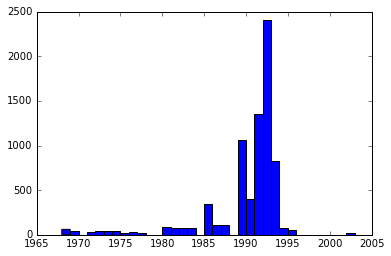

In [6]:
x=plt.hist(df['strain_1_dates'], bins = 35)

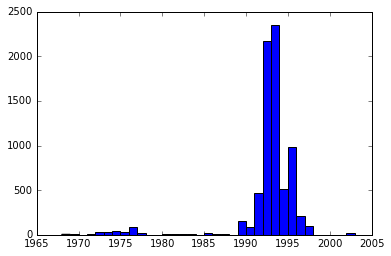

In [7]:
x=plt.hist(df['strain_2_dates'], bins = 35)

#### Function to make a train/test split based on particular date 


In [8]:
def splitByYear(df, year):
    train = df.loc[((df['strain_1_dates']<=year)& (df['strain_2_dates'] <=year))]
    test = df.loc[((df['strain_1_dates']>year) |(df['strain_2_dates'] >year))]
    return {'train':train, 'test':test}

In [9]:
split = splitByYear(df, 1994)
train = split['train']
test = split['test']

#X: the independent variables or features
X = df.drop(['AG1', 'AG2', 'AGDIST', 'HD', 
                   'strain_1_dates', 'strain_2_dates', 'strain_1_cluster', 'strain_2_cluster'], axis = 1)

# y: the dependent variable, the thing we're trying to predict
y = df['AGDIST']



xtrain = train.drop(['AG1', 'AG2', 'AGDIST', 'HD', 
                       'strain_1_dates', 'strain_2_dates', 'strain_1_cluster', 'strain_2_cluster'], axis = 1)
ytrain = train['AGDIST']

xtest = test.drop(['AG1', 'AG2', 'AGDIST', 'HD', 
                       'strain_1_dates', 'strain_2_dates', 'strain_1_cluster', 'strain_2_cluster'], axis = 1)
ytest = test['AGDIST']

Testing that the training and test sets are disjoint

In [10]:
merged = pd.concat([train, test])
assert max(merged.duplicated())==0
assert not pd.isnull(merged).values.any()

Creating a dataset with interaction terms

In [11]:
iX = df.drop(['AG1', 'AG2', 'AGDIST', 'HD', 
                   'strain_1_dates', 'strain_2_dates', 'strain_1_cluster', 'strain_2_cluster'], axis = 1)
for col1 in X.columns:
    for col2 in X.columns:
        if col1<col2:
            if max(iX[col1]*iX[col2]) >0:
                iX['%s:%s' %(col1, col2)] = (iX[col1]*iX[col2])
    

Splitting this dataset into train and test sets

In [12]:
ixtrain = iX.loc[((df['strain_1_dates']<=1994)& (df['strain_2_dates'] <=1994))]
ixtest = iX.loc[((df['strain_1_dates']>1994) |(df['strain_2_dates'] >1994))]


Creating a dataset that includes just the hamming distance (hd), or the hamming distance and the other x variables (hdx)

In [13]:
hdtest = np.array(test['HD']).reshape(-1,1)
hdtrain = train['HD']
hdtrain=np.array(hdtrain).reshape(-1,1)
print(hdtrain.shape)

hdxtrain = train.drop(['AG1', 'AG2', 'AGDIST', 
                       'strain_1_dates', 'strain_2_dates', 'strain_1_cluster', 'strain_2_cluster'], axis = 1)
hdxtrain['HD'] = train['HD']
hdxtest = test.drop(['AG1', 'AG2', 'AGDIST',
                     'strain_1_dates', 'strain_2_dates', 'strain_1_cluster', 'strain_2_cluster'], axis = 1)


(6092, 1)


Creating a cross-validation split by cluster (of just the training data)

In [14]:
cvlist = cv(train, 'strain_1_cluster', 'strain_2_cluster')

Checking that the train and test sets are disjoint for each split in cvlist

In [15]:
for tple in cvlist:
    assert set(tple[0]).isdisjoint(tple[1])

### Checking visually that the training and test data are disjoint
Looks good

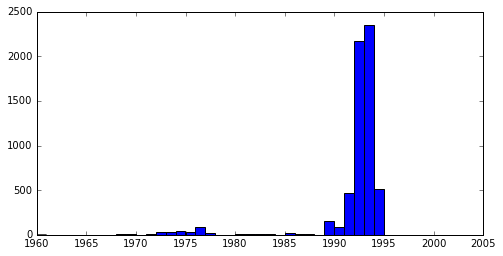

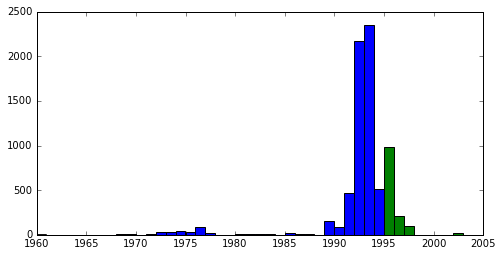

In [16]:
fig_size = [8, 4]
plt.rcParams["figure.figsize"] = fig_size
 
x= plt.hist((train[['strain_1_dates', 'strain_2_dates']].max(axis=1)), bins=range(1960,2004))
figure(2)
y=plt.hist((train[['strain_1_dates', 'strain_2_dates']].max(axis=1)), bins=range(1960,2004))
z=plt.hist((test[['strain_1_dates', 'strain_2_dates']].max(axis=1)), bins=range(1960,2004), color = 'g')


#### Here's a function to plot the coefficients of a linear model

In [17]:
def coefplot(coefs, cutoff = 0.01, interaction = False):
    fig_size = [20, 10]
    plt.rcParams["figure.figsize"] = fig_size
    if interaction:
        params = pd.DataFrame(data = coefs, index = ixtrain.columns)
    else:
        params = pd.DataFrame(data = coefs, index = xtrain.columns)
    
    params = params.loc[(params[0]<-cutoff)|(params[0]>cutoff)]
    params = params.sort_values(0)
    fig, ax = plt.subplots()
    x = range(len(params.index))
    ax.scatter(x, list(params[0]), color="g", s=10)
    xticks(x, x)
    ax.set_xlim([-1, len(params)])
    
    ax.set_xticklabels(["\n".join(list(name)) for name in params.index],
                       fontsize=10)

### Let's have a look at how far apart in years the antigenic distance comparisons we have are


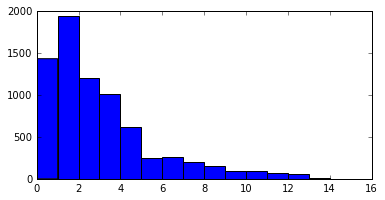

In [18]:
fig_size = [6, 3]
plt.rcParams["figure.figsize"] = fig_size

x=plt.hist(df['strain_2_dates']-df['strain_1_dates'], bins = range(16))

### What is the distribution of antigenic distances?


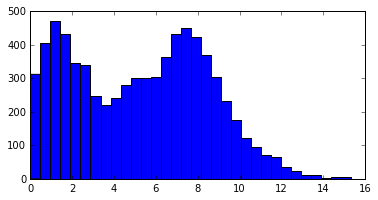

In [19]:
fig_size = [6, 3]
plt.rcParams["figure.figsize"] = fig_size

x=plt.hist(df['AGDIST'], bins = 32)

### A function to draw a few plots of the errors for a given model and xtest data

In [41]:
def errorplot(clf, xtst):
    fig_size = [15, 6]
    plt.rcParams["figure.figsize"] = fig_size
    
    #Make a dataframe 'errors' to hold the ytest, predicted values, and errors, then sort by the error size
    errors = pd.DataFrame()
    errors['AGDIST'] = test['AGDIST']
    errors['predicted'] = clf.predict(xtst)
    errors['error'] = errors['predicted'] - errors['AGDIST']
    errors['date'] = test['strain_2_dates']
    errors = errors.sort_values('error')

    plt.figure(3)
    errors = errors.sort_values('date')
    
    #Add some random noise to the dates to avoid overplotting
    errors['jittered_dates'] = errors['date'] + np.random.uniform(-2, 2, len(test))
    
    plt.scatter(errors['jittered_dates'], errors['AGDIST'], color = 'g', s=3, marker='o')
    plt.scatter(errors['jittered_dates'], errors['predicted'], color = 'b', s=3)
    plt.scatter(errors['jittered_dates'], errors['error'], color = 'r', s=3)
    plt.xlabel('Strain 2 dates')
    plt.ylabel('Antigenic distance')
    red_patch = mpatches.Patch(color='red', label='Error')
    green_patch = mpatches.Patch(color='green', label='True value')
    blue_patch = mpatches.Patch(color='blue', label='Predicted value')
    plt.legend(handles=[red_patch, green_patch, blue_patch])
    
    plt.figure(4)
    plt.hist(errors['error'], bins=30)
    plt.xlabel('error size')
    plt.ylabel('frequency')
    plt.axvline(x=mean(errors['error']), color='r')
    

### Now we try fitting various ml models

In [72]:
clf=sklm.LinearRegression()
clf.fit(xtrain, ytrain)
score=clf.score(xtest, ytest)
print(score)

-4.84969453647e+24


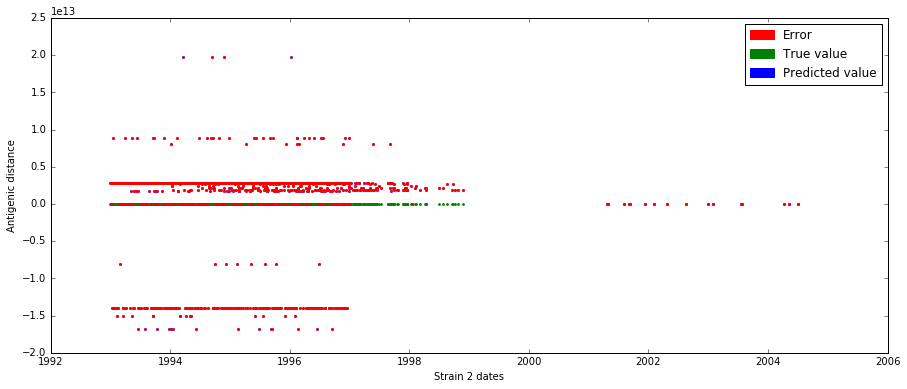

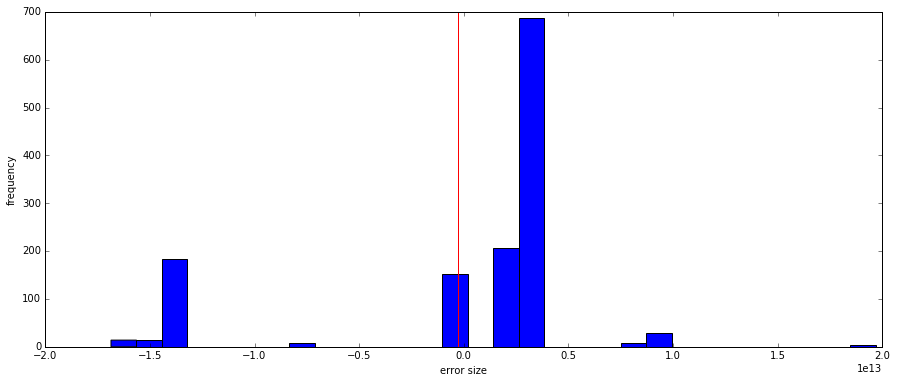

In [73]:
errorplot(clf, xtest)

Oh dear, that didn't work very well. Let's have a look at the coefficients.

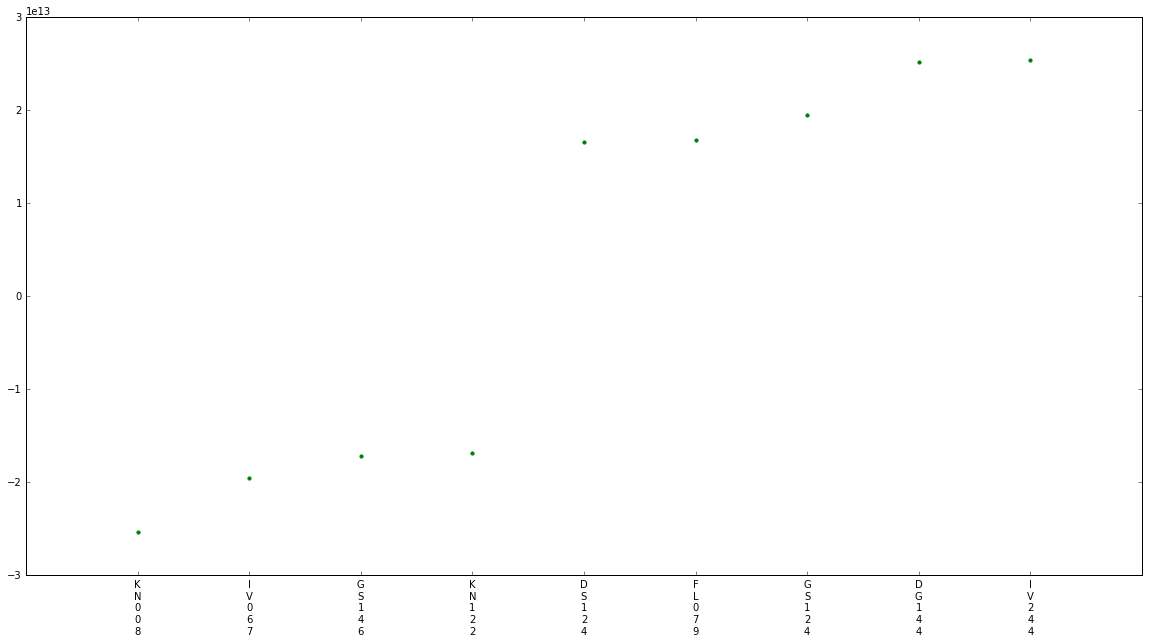

In [143]:
coefplot(clf.coef_, cutoff = 10000000000000)

In [81]:
sum(xtrain['IV244'])

40

In [79]:
def unseenParameters(clf, xtrain):
    unseen = []
    for column in xtrain.columns:
        if sum(xtrain[column])==0:
            unseen.append(column)
    params = pd.DataFrame(data = clf.coef_, index = xtrain.columns, columns=('Coefficient',))
    return(params.loc[unseen])

In [80]:
unseenParameters(clf, xtrain)

,Coefficient
DT135,-2.424669e+11
ET135,-8.226465e+11
GT135,-6.024164e+11
IL226,1.210778e+11
IQ226,-9.484628e+11
KT135,-6.495633e-03
LV226,6.936030e-04
NS262,-1.108644e-22
ST262,0.000000e+00


The model is giving enormous weights  to some substitutions which are not just the ones that don't appear in the training data. Maybe these are the ones that are collinear?

### As a baseline, how well can we do with just Hamming Distances?

In [27]:
hdclf=sklm.LinearRegression()
hdclf.fit(hdtrain, ytrain)
score=hdclf.score(hdtest, ytest)
print(score)

0.538896864456


In [28]:
hdtest.shape

(1308, 1)

This is better than Oskar's model.
Anything below an r^2 of 0.55 is worse than just counting the number of mutations

(0, 17)

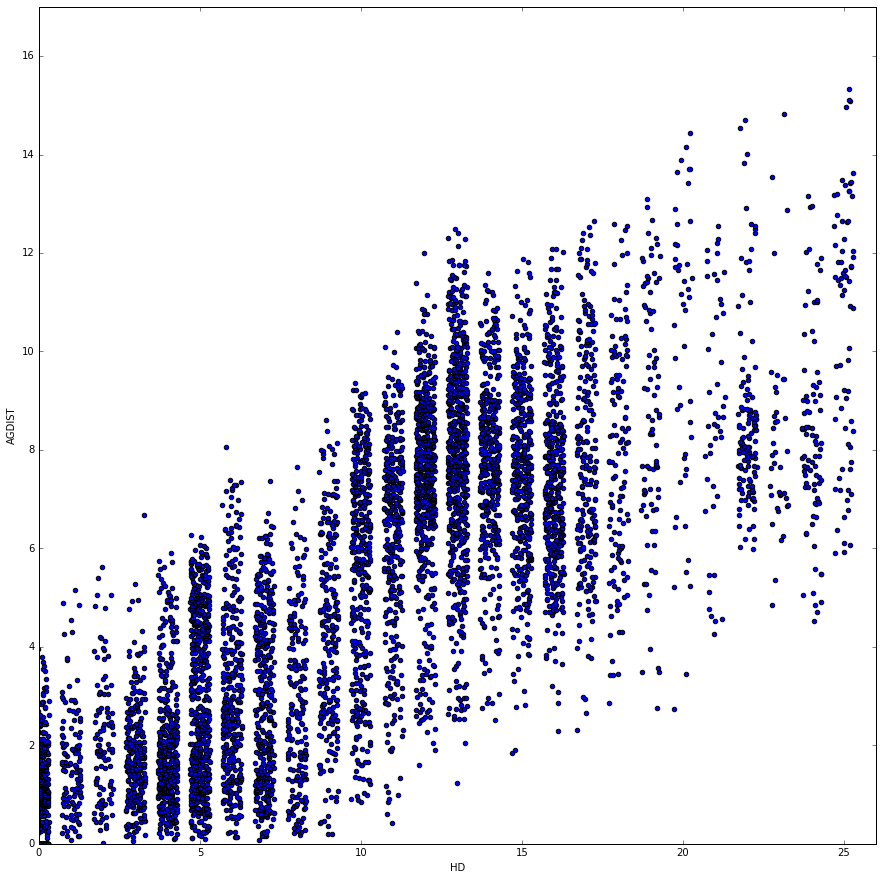

In [29]:
fig_size = [15, 15]
plt.rcParams["figure.figsize"] = fig_size
jitteredHD = df['HD'] + np.random.uniform(-0.3, 0.3, len(df))
plt.xlabel('HD')
plt.ylabel('AGDIST')
plt.scatter(jitteredHD, df['AGDIST'])
plt.xlim(0,26)
plt.ylim(0,17)

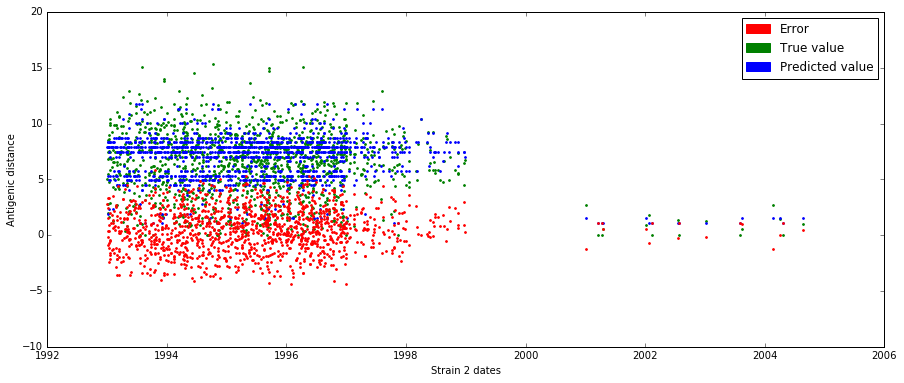

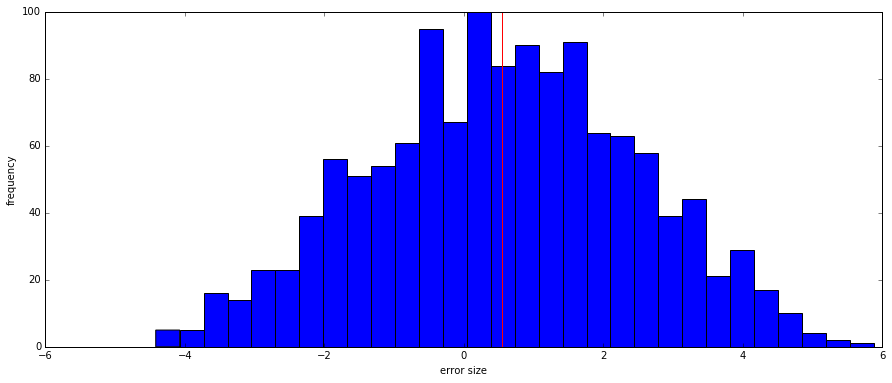

In [46]:
errorplot(hdclf, hdtest)

The errors here are skewed towards overestimating the distances

### Now let's try a regularized linear regression

Using sklearn.linear_model.Ridge

In [35]:
scores1 = []
for a in [0.01, 0.1, 1, 10 , 100, 1000, 1500, 2000, 3000]:
    clf1 = sklm.Ridge(alpha = a)
    clf1.fit(xtrain, ytrain)
    scores1.append(clf1.score(xtest, ytest))
print(scores1)

[0.58732485521787181, 0.58789661814330929, 0.59303620992188688, 0.61845454936290101, 0.650201675768458, 0.63240098440489578, 0.61783108806370868, 0.60286887322182636, 0.57225890685328151]


In [36]:
scores1 = []
scores2 = []
for a in [5, 10, 20, 40, 80, 100, 200, 300, 400]:
    clf1 = sklm.Ridge(alpha = a)
    clf1.fit(xtrain, ytrain)
    scores1.append(clf1.score(xtest, ytest))
    scores2.append(clf1.score(xtrain,ytrain))
print(scores1)

print('The fit on the training data is')
print(scores2)


[0.60804480365827063, 0.61845454936290101, 0.62974337506406997, 0.64033185433305451, 0.64842435022813083, 0.650201675768458, 0.65244746732256642, 0.65116368822519322, 0.6489430812752176]
The fit on the training data is
[0.91200778930460202, 0.91155376382112074, 0.91068565833064374, 0.90901287486711546, 0.90580462345300761, 0.90425964540147963, 0.89705838217032818, 0.89056647846399828, 0.88459704380161841]


In [48]:
clf = sklm.Ridge(alpha = 300)
clf.fit(xtrain,ytrain)
clf.score(xtest, ytest)

0.65116368822519322

#### Let's see what the errors look like

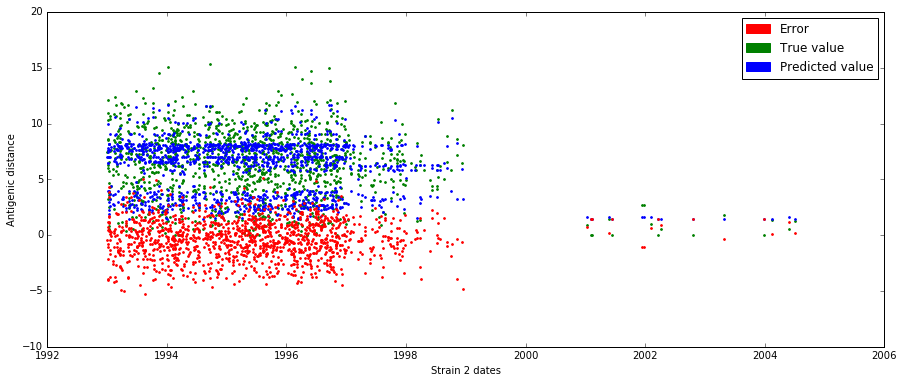

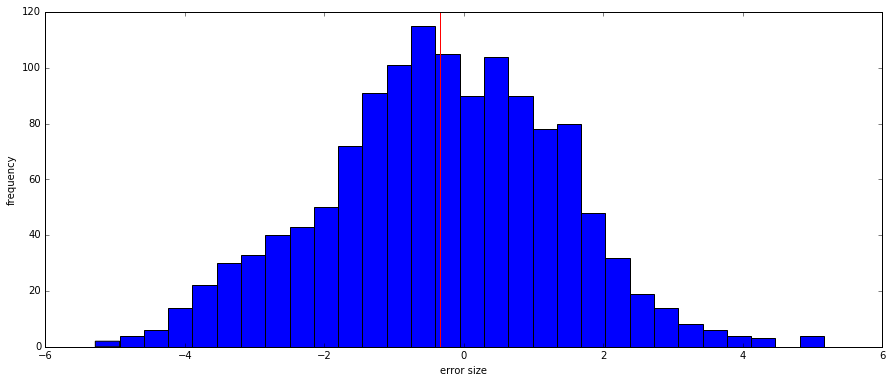

In [49]:
errorplot(clf, xtest)

The errors here are skewed towards underestimating the distances - probably because unseen mutations are given a value of 0.

Which mutations do not appear in the training data?

In [69]:
unseenParameters(clf, xtrain)

,0
DT135,0.0
ET135,0.0
GT135,0.0
IL226,0.0
IQ226,0.0
KT135,0.0
LV226,0.0
NS262,0.0
ST262,0.0


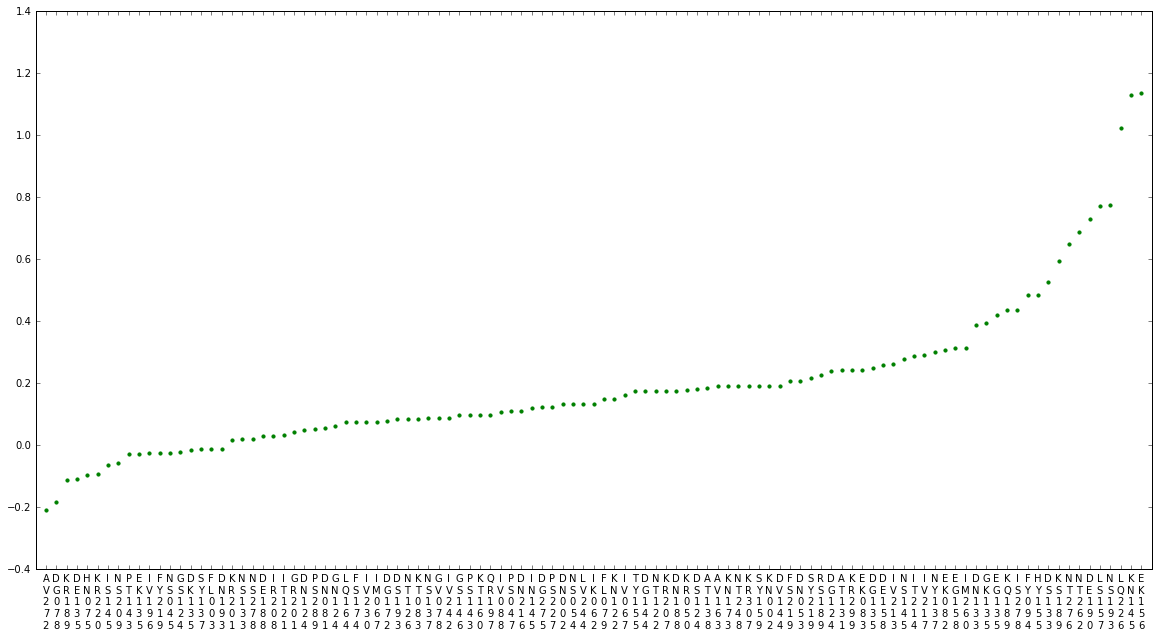

In [97]:
coefplot(clf.coef_)

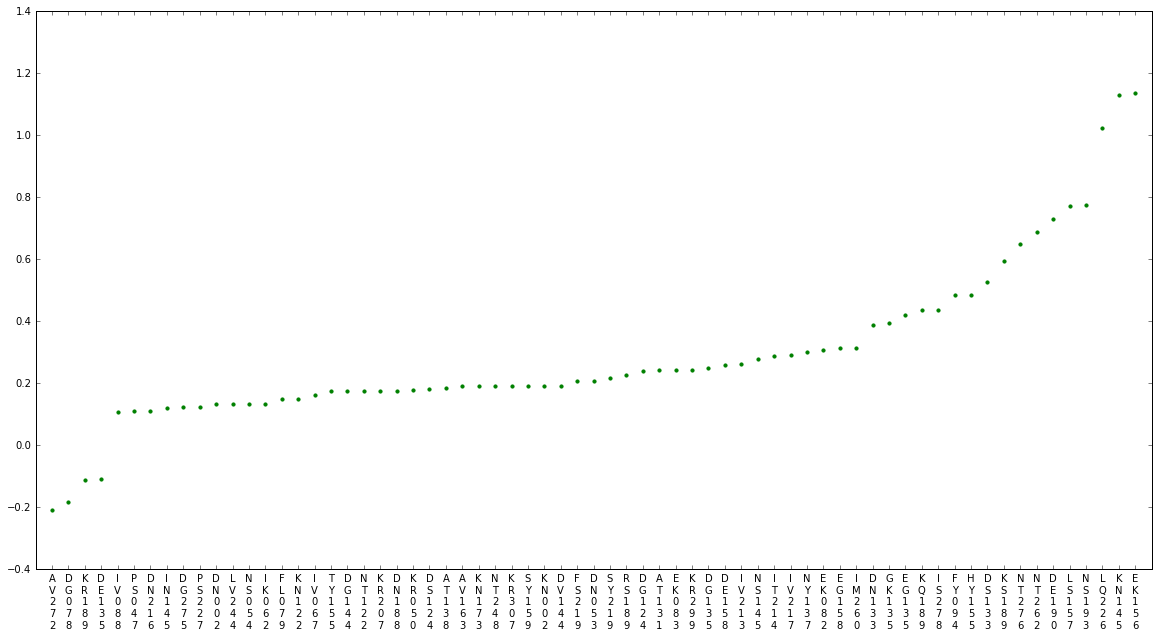

In [138]:
coefplot(clf.coef_, cutoff = 0.1)

### What happens if we include hamming distance in the model?

In [98]:

scores1 = []
for a in [5, 10, 20, 40, 80, 100, 200, 300, 400]:
    clf1 = sklm.Ridge(alpha = a)
    clf1.fit(hdxtrain, ytrain)
    scores1.append(clf1.score(hdxtest, ytest))
print(scores1)

[0.60693962180528782, 0.61856129007013905, 0.62991981627591964, 0.63935973171697114, 0.6454637040026161, 0.64656053313406026, 0.64703661093608122, 0.64515692650493284, 0.64280049073422652]


Seems like accuracy is slightly worse but basically the same. The errors look pretty similar, maybe a tiny bit better around the extremes

### Let's try a lasso penalised regression, and force the coefficients to be positive

In [99]:
scores =[]
for a in [0.001, 0.005, 0.008, 0.009, 0.01, 0.015, 0.05, 0.1, 1]:
    clf1 = sklm.Lasso(alpha = a, positive=True)
    clf1.fit(xtrain, ytrain)
    scores.append(clf1.score(xtest, ytest))
print(scores)


[0.58672195635350066, 0.58548399159450715, 0.59143179954570724, 0.59297721772911949, 0.59440174549624158, 0.60085168308897896, 0.58844608212208083, 0.59446800361201424, 0.021393838716362357]


In [100]:
clf = sklm.Lasso(alpha = 0.015, positive=True)
clf.fit(xtrain, ytrain)
clf.score(xtest, ytest)

0.60085168308897896

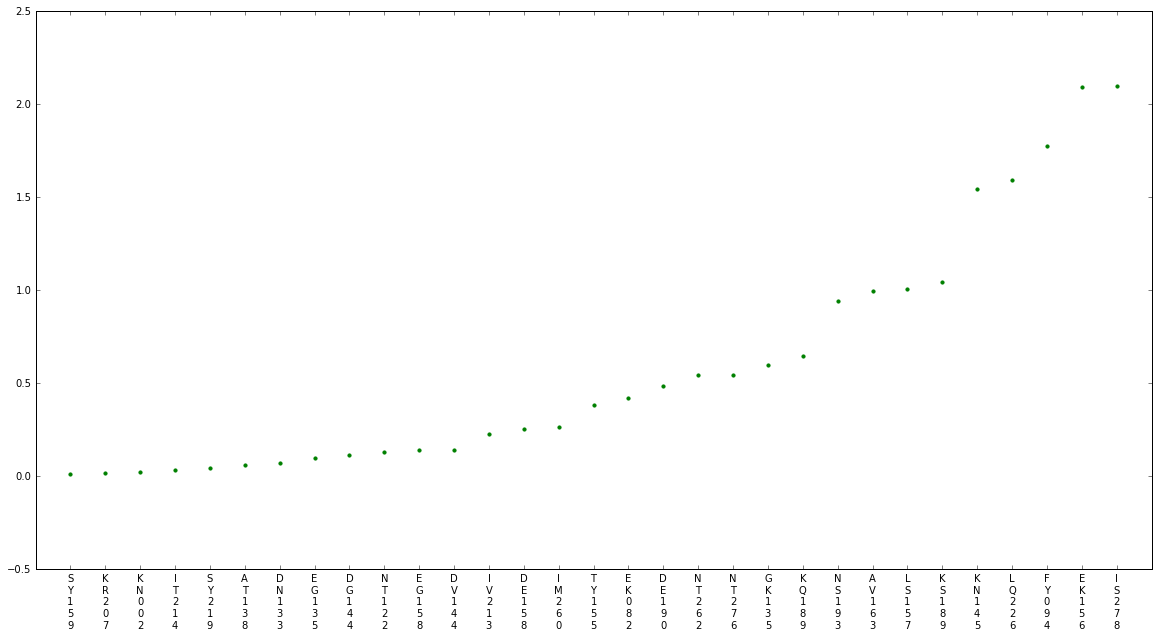

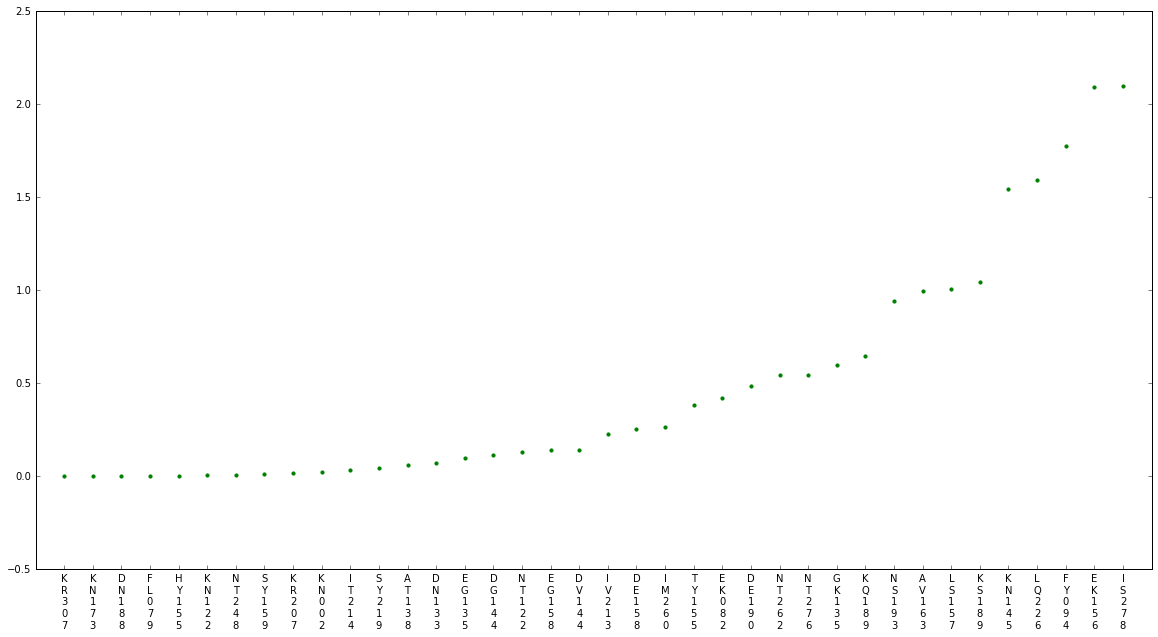

In [106]:
coefplot(clf.coef_, cutoff = 0.01)
plt.figure(2)
coefplot(clf.coef_, cutoff = 0)

### Let's try including the interaction terms in a lasso model

In [108]:
iscores =[]
for a in [0.001, 0.005, 0.008, 0.009, 0.01, 0.015, 0.05, 0.1, 1]:
    iclf = sklm.Lasso(alpha = a, positive=True)
    iclf.fit(ixtrain, ytrain)
    iscores.append(iclf.score(ixtest, ytest))
print(iscores)

[0.50379204352790663, 0.5223909783298295, 0.55012194613887511, 0.55836353274493611, 0.56553209039451713, 0.59128728015351584, 0.58574342894024445, 0.59476586906619267, 0.021393838716362357]


In [109]:
iscores =[]
for a in [0.01, 0.015, 0.05, 0.1, 0.2, 0.3]:
    iclf = sklm.Lasso(alpha = a)
    iclf.fit(ixtrain, ytrain)
    iscores.append(iclf.score(ixtest, ytest))
print(iscores)

[0.56742746436043445, 0.59054211215314756, 0.58574365987370225, 0.59476598363781474, 0.57155085256642968, 0.49854887972814238]


In [83]:
iclf = sklm.Lasso(alpha = 0.1 )
iclf.fit(ixtrain, ytrain)
iclf.score(ixtest, ytest)

0.59476598363781474

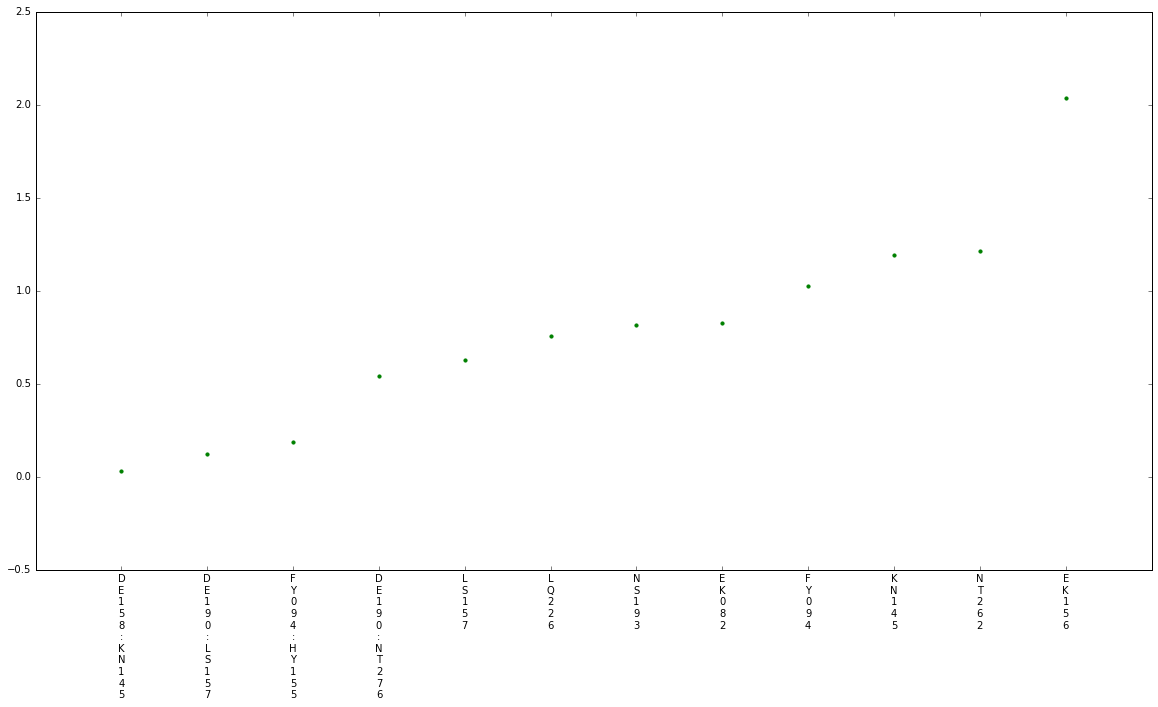

In [86]:
coefplot(iclf.coef_, cutoff=0, interaction=True)
plt.figure(2)

In [90]:
def getcoefs(coefs, cutoff=0):
    cfs = pd.DataFrame(data = coefs, index = ixtrain.columns)
    cfs = cfs.loc[(cfs[0]<-cutoff)|(cfs[0]>cutoff)]
    cfs = cfs.sort_values(0)
    return cfs


The distances for the 3 interaction terms (from right to left) are 52.3, 26.8 and 14.9. 

52.3 is too far apart to be a plausible distance, but 26.8 and 14.9 seem to be valid interaction terms

Let's find out whether DE190 and NT276 ever occur apart

In [91]:
print(sum(ixtrain['NT276']))
print(sum(ixtrain['DE190']))
print(sum(ixtrain['NT276'] & (ixtrain['DE190'])))
print(sum(ixtrain['NT276'] & ~(ixtrain['DE190'])))
print(sum(~(ixtrain['NT276']) & (ixtrain['DE190'])))

2105
2382
1945
160
437


In [92]:
getcoefs(iclf.coef_)

,0
DE158:KN145,0.031727
DE190:LS157,0.121392
FY094:HY155,0.186817
DE190:NT276,0.540139
LS157,0.627409
LQ226,0.756379
NS193,0.814886
EK082,0.827604
FY094,1.025167
KN145,1.191510


### Let's try using interaction terms with a ridge model

In [115]:
iscores =[]
for a in [0.01, 0.1, 1, 10, 100, 1000]:
    iclf = sklm.Ridge(alpha = a)
    iclf.fit(ixtrain, ytrain)
    iscores.append(iclf.score(ixtest, ytest))
print(iscores)

[-1.5502426424747624, 0.1033809312441092, 0.43133870380974859, 0.50293940850246055, 0.50332728567881213, 0.54730101603221426]


In [116]:
iscores =[]
for a in [100, 1000, 2000, 5000, 10000]:
    iclf = sklm.Ridge(alpha = a)
    iclf.fit(ixtrain, ytrain)
    iscores.append(iclf.score(ixtest, ytest))
print(iscores)

[0.50332728567881213, 0.54730101603221426, 0.5645280458107369, 0.57543823617344469, 0.56313095287714687]


In [117]:
iclf = sklm.Ridge(alpha = 5000 )
iclf.fit(ixtrain, ytrain)
iclf.score(ixtest, ytest)

0.57543823617344469

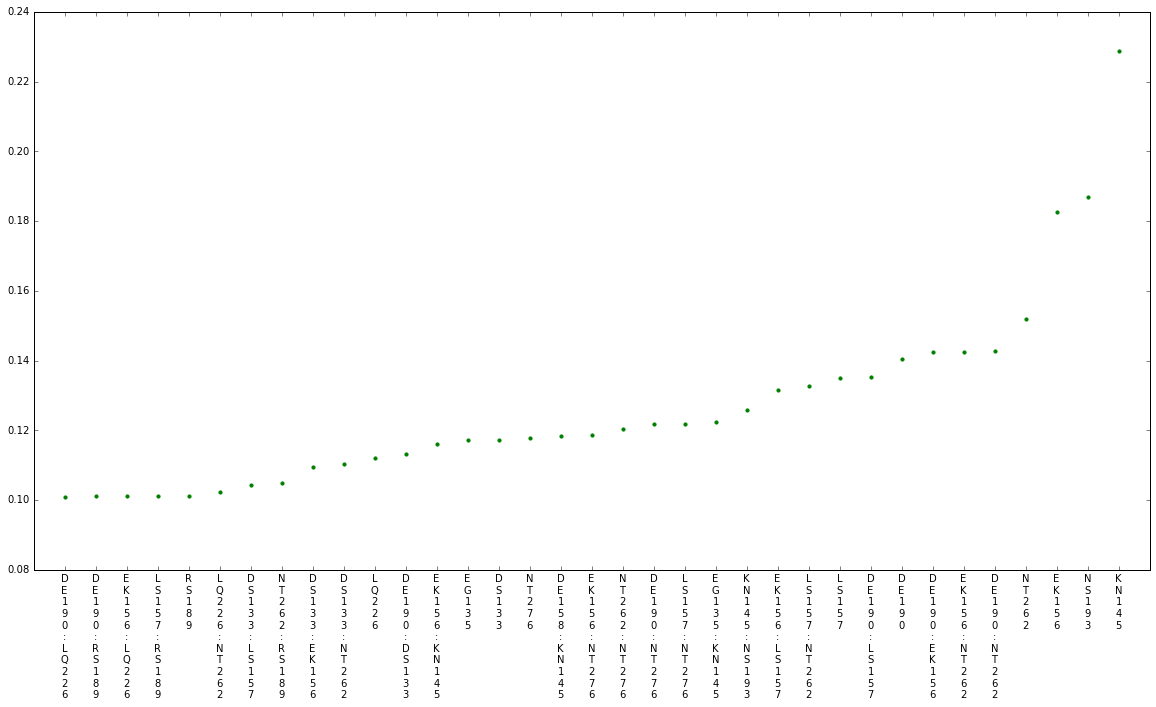

In [118]:
coefplot(iclf.coef_, cutoff=0.1, interaction=True)

This model has far too many terms and gets a worse fit than using the ridge model without interaction terms - I guess it's overfitting

### Let's try using support vector machines!

In [119]:
clf2 = svm.SVR()
clf2.fit(xtrain, ytrain)
svmscore=clf2.score(xtest, ytest)
print(svmscore)

0.649515653029


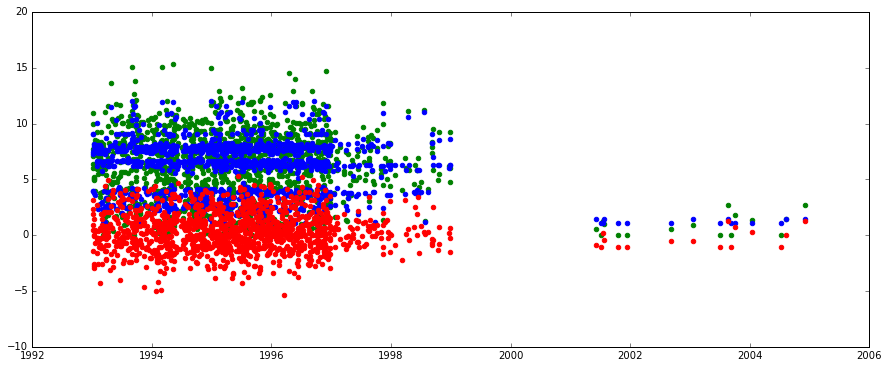

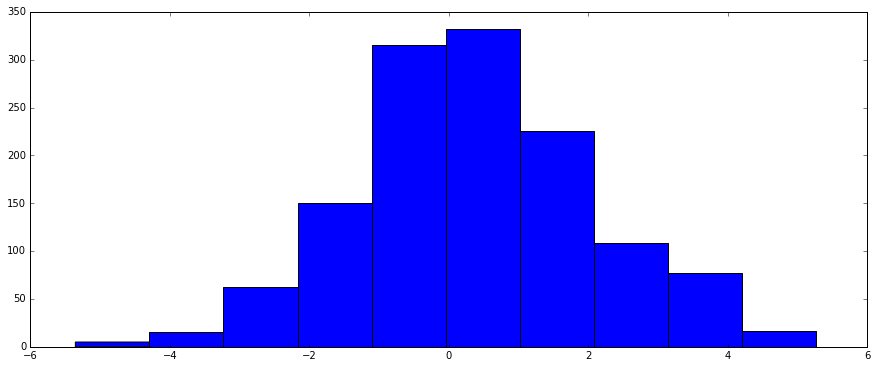

In [120]:
errorplot(clf2, xtest)

### These are pretty slow. Let's try random forests

In [121]:
num = [10, 50, 200, 500, 1000]
depth= [5,10, 12, 15, 20, 30, 40]
scores=np.empty([len(depth)+1, len(num)+1])
scores[0,1:] = num
scores[1:,0] = depth

In [122]:
for i in range(len(num)):
    for j in range(len(depth)):
        clf3 = ensemble.RandomForestRegressor(n_estimators=num[i], max_depth=depth[j])
        clf3.fit(xtrain, ytrain)
        rfscore=clf3.score(xtest, ytest)
        scores[j+1][i+1]=rfscore
print(scores)


[[    0.       10.       50.      200.      500.     1000.   ]
 [    5.        0.305     0.388     0.344     0.387     0.379]
 [   10.        0.289     0.421     0.364     0.375     0.374]
 [   12.        0.169     0.324     0.368     0.352     0.35 ]
 [   15.        0.392     0.37      0.339     0.355     0.364]
 [   20.        0.603     0.324     0.361     0.338     0.355]
 [   30.        0.362     0.314     0.334     0.359     0.368]
 [   40.        0.354     0.399     0.356     0.389     0.365]]


The scores are significantly worse than the linear model. 

In [47]:
num2 = [5, 10, 15, 20, 30, 40]
maxlf= [10, 50, 100, 200, 500]
scores2=np.empty([len(maxlf)+1, len(num2)+1])
scores2[0,1:] = num2
scores2[1:,0] = maxlf

In [48]:
for i in range(len(num2)):
    for j in range(len(maxlf)):
        clf3 = ensemble.RandomForestRegressor(n_estimators=num2[i], max_leaf_nodes=maxlf[j])
        clf3.fit(xtrain, ytrain)
        rfscore=clf3.score(xtest, ytest)
        scores2[j+1][i+1]=rfscore
print(scores2)

[[   0.       5.      10.      15.      20.      30.      40.   ]
 [  10.       0.594    0.419    0.424    0.503    0.471    0.463]
 [  50.       0.381    0.382    0.415    0.455    0.391    0.427]
 [ 100.       0.393    0.483    0.335    0.409    0.377    0.408]
 [ 200.       0.376    0.195    0.328    0.384    0.322    0.437]
 [ 500.       0.644    0.427    0.459    0.364    0.361    0.291]]


In [94]:
clf4 = ensemble.RandomForestRegressor(n_estimators=11, max_leaf_nodes=100)
clf4.fit(xtrain, ytrain)
rfscore2=clf4.score(xtest, ytest)
print(rfscore2)

0.402497521208


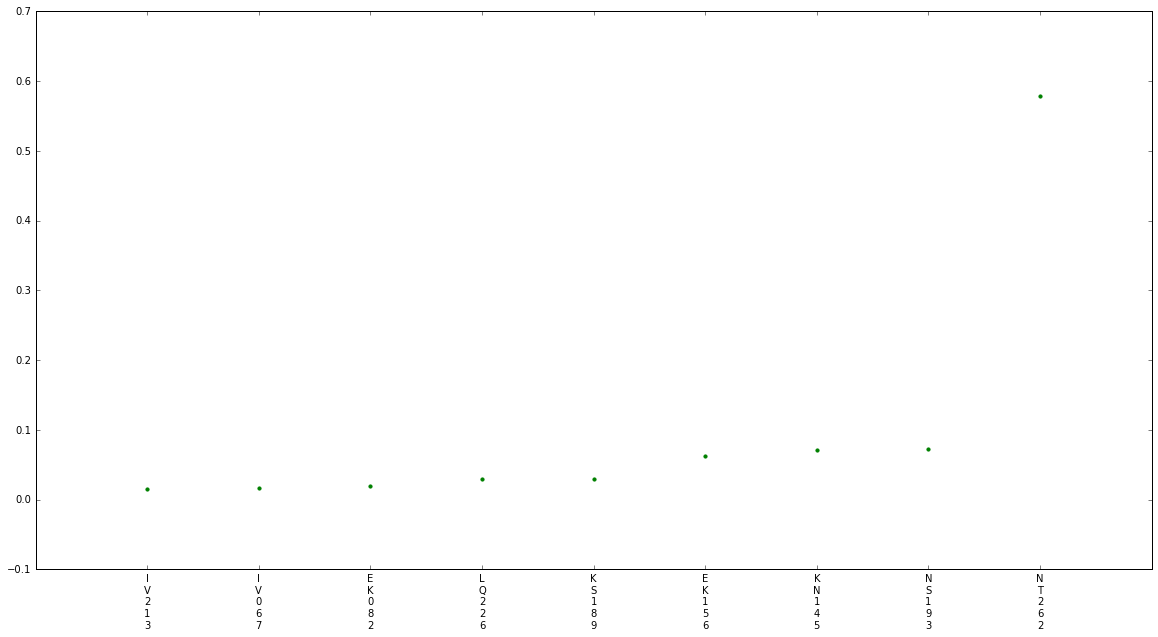

In [95]:
coefplot(clf4.feature_importances_)

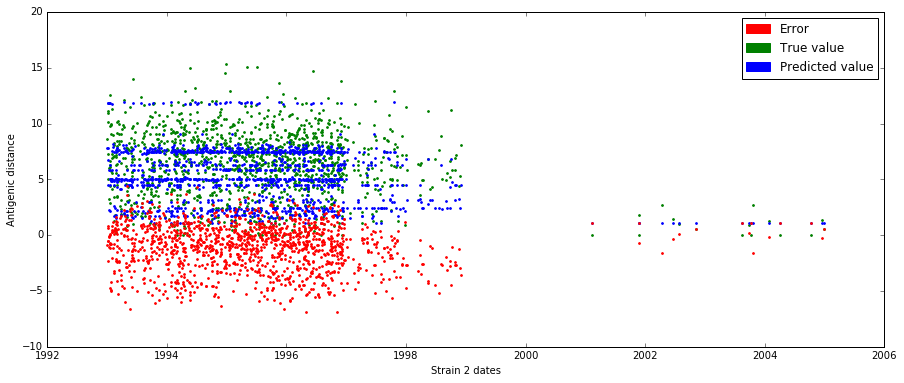

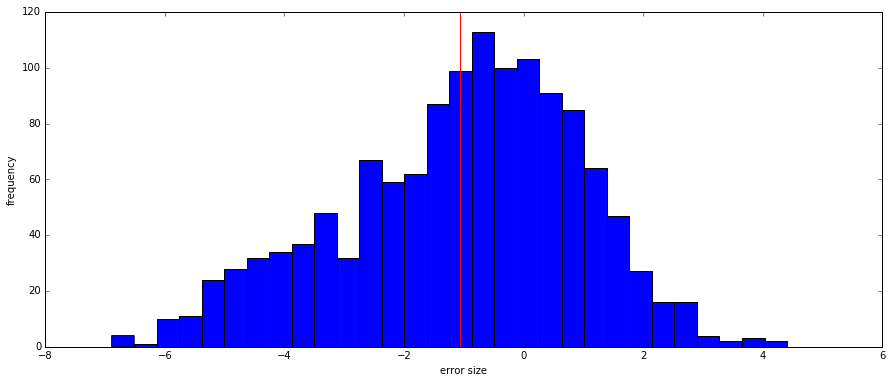

In [96]:
errorplot(clf4, xtest)

The errors here are pretty skewed towards overestimating the distances - interesting

In [93]:
lolo = LeaveOneLabelOut(train['strain_1_cluster'])
cvscores = cross_val_score(clf4, xtrain, ytrain, cv = lolo)
print(cvscores)


[ 0.796  0.875  0.116  0.865  0.656  0.768 -0.186]


(6092,)
(6092,)


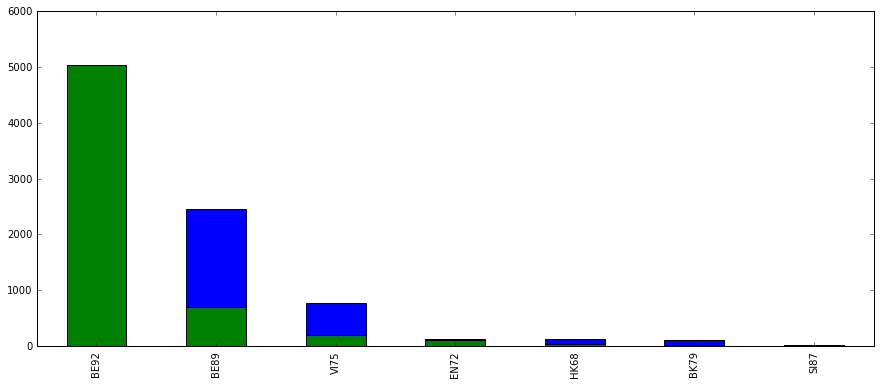

In [109]:
train.strain_1_cluster.value_counts().plot(kind='bar', color = 'b')
train.strain_2_cluster.value_counts().plot(kind='bar', color = 'g')
print(train.strain_1_cluster.shape)
print(train.strain_2_cluster.shape)

Using the custom cross validation object I made earlier to try crossvalidation

In [97]:
customcvscores = cross_val_score(clf4, xtrain, ytrain, cv = cvlist)
print(customcvscores)

[ 0.747  0.877 -0.114  0.755  0.446  0.465  0.05  -0.083]


Trying more SVMs. These are pretty slow!

In [48]:
scores3=np.empty([7,6])
cvar = [0.01, 0.1, 1, 10, 100]
epsilonvar= [0.001, 0.01, 0.1, 1, 10, 100]
scores3[0,1:] = cvar
scores3[1:,0] = epsilonvar

In [49]:
for i in range(5):
    for j in range(6):
        clf5 = svm.SVR(C = cvar[i], epsilon = epsilonvar[j])
        clf5.fit(xtrain, ytrain)
        svmscore=clf5.score(xtest, ytest)
        scores3[j+1][i+1]=svmscore
print(scores3)

In [98]:
scores4=np.empty([7,6])
cvar = [0.5, 1, 2, 4, 10]
epsilonvar= [0.001, 0.01, 0.1, 0.5, 1, 2]
scores4[0,1:] = cvar
scores4[1:,0] = epsilonvar

for i in range(5):
    for j in range(6):
        clf5 = svm.SVR(C = cvar[i], epsilon = epsilonvar[j])
        clf5.fit(xtrain, ytrain)
        svmscore=clf5.score(xtest, ytest)
        scores4[j+1][i+1]=svmscore
print(scores4)

[[  0.      0.5     1.      2.      4.     10.   ]
 [  0.001   0.653   0.649   0.639   0.636   0.614]
 [  0.01    0.653   0.649   0.64    0.635   0.614]
 [  0.1     0.653   0.65    0.643   0.636   0.619]
 [  0.5     0.659   0.658   0.653   0.645   0.626]
 [  1.      0.659   0.66    0.658   0.656   0.646]
 [  2.      0.645   0.649   0.647   0.647   0.636]]


In [23]:
with open('svm scores grid 2', 'w') as f:
    f.write(repr(scores4))

In [26]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

print(scores4)

In [28]:
scores5=np.empty([6,3])
cvar = [0.5,10]
epsilonvar= [0.5, 0.8, 1, 1.2, 1.4]
scores5[0,1:] = cvar
scores5[1:,0] = epsilonvar

for i in range(2):
    for j in range(5):
        clf5 = svm.SVR(C = cvar[i], epsilon = epsilonvar[j])
        clf5.fit(xtrain, ytrain)
        svmscore=clf5.score(xtest, ytest)
        scores5[j+1][i+1]=svmscore
print(scores5)

In [62]:

n_estimators = [5, 10, 20, 25, 30, 35]
learnrate= [0.01, 0.1, 1, 10, 15, 20, 40]
ABscores=np.empty([len(learnrate)+1, len(n_estimators)+1])
ABscores[0,1:] = n_estimators
ABscores[1:,0] = learnrate


for i in range(len(learnrate)):
    for j in range(len(n_estimators)):
        ABclf = sk.ensemble.AdaBoostRegressor(n_estimators=n_estimators[j], learning_rate=learnrate[i])
        ABclf.fit(xtrain, ytrain)
        ABscores[i+1,j+1] = ABclf.score(xtest, ytest)
        
print(ABscores)


[[  0.      5.     10.     20.     25.     30.     35.   ]
 [  0.01    0.285   0.442   0.443   0.442   0.441   0.278]
 [  0.1     0.277   0.64    0.639   0.643   0.64    0.536]
 [  1.      0.649   0.57    0.601   0.634   0.642   0.594]
 [ 10.     -1.813  -0.365  -0.51    0.436  -1.639  -0.466]
 [ 15.     -3.14   -1.315  -0.207  -5.457  -2.472  -1.298]
 [ 20.     -1.464  -1.611  -4.331  -4.404  -4.443  -4.189]
 [ 40.     -3.769  -2.372  -2.356  -3.466  -2.551  -4.39 ]]


In [63]:
n_estimators = [5, 10, 20, 25, 30, 35]
learnrate= [0.1, 1, 2, 5]
ABscores=np.empty([len(learnrate)+1, len(n_estimators)+1])
ABscores[0,1:] = n_estimators
ABscores[1:,0] = learnrate


for i in range(len(learnrate)):
    for j in range(len(n_estimators)):
        ABclf = sk.ensemble.AdaBoostRegressor(n_estimators=n_estimators[j], learning_rate=learnrate[i])
        ABclf.fit(xtrain, ytrain)
        ABscores[i+1,j+1] = ABclf.score(xtest, ytest)
        
print(ABscores)

[[  0.      5.     10.     20.     25.     30.     35.   ]
 [  0.1     0.453   0.454   0.636   0.637   0.545   0.536]
 [  1.      0.644   0.606   0.66    0.665   0.671   0.6  ]
 [  2.      0.574   0.61    0.637   0.628   0.596   0.623]
 [  5.      0.654   0.586   0.111   0.499  -0.825   0.399]]


In [64]:
ABclf = sk.ensemble.AdaBoostRegressor(n_estimators=30, learning_rate=0.1)
ABclf.fit(xtrain, ytrain)
ABclf.score(xtest, ytest)

0.5348821195711837

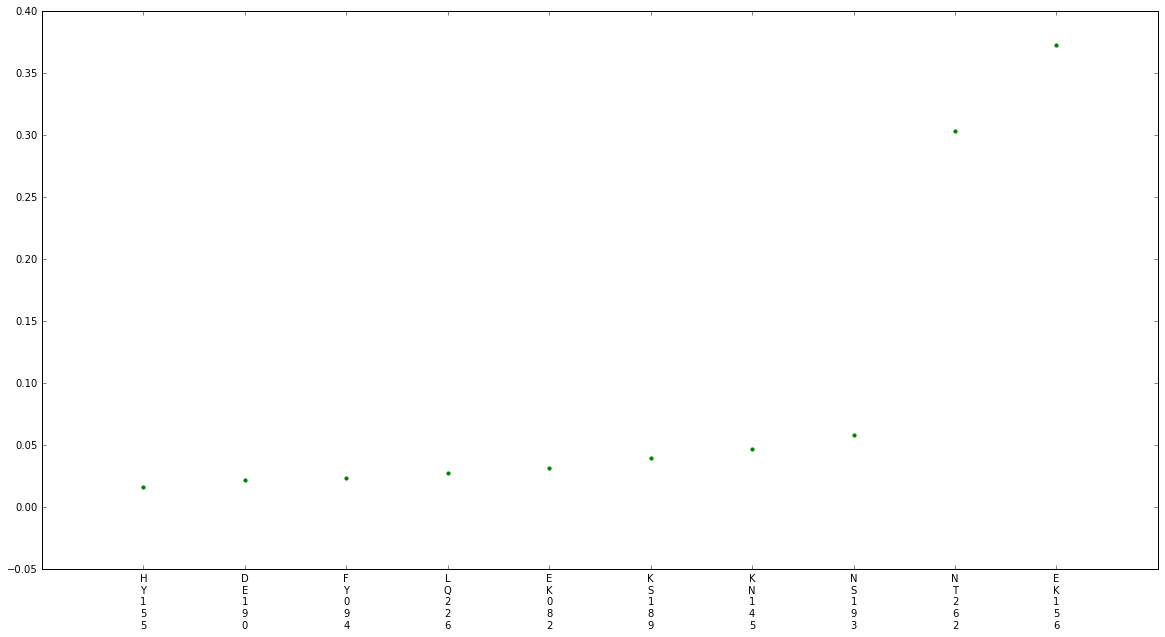

In [65]:
coefplot(ABclf.feature_importances_, cutoff = 0.01)

In [66]:
n_estimators = [5, 10, 20, 25, 30, 35]
learnrate= [0.1, 1, 2, 5]
ABscores=np.empty([len(learnrate)+1, len(n_estimators)+1])
ABscores[0,1:] = n_estimators
ABscores[1:,0] = learnrate


for i in range(len(learnrate)):
    for j in range(len(n_estimators)):
        ABclf = sk.ensemble.AdaBoostRegressor(n_estimators=n_estimators[j], learning_rate=learnrate[i])
        ABclf.fit(ixtrain, ytrain)
        ABscores[i+1,j+1] = ABclf.score(ixtest, ytest)
        
print(ABscores)

[[  0.136   5.     10.     20.     25.     30.     35.   ]
 [  0.1     0.452   0.446   0.636   0.633   0.634   0.64 ]
 [  1.      0.541   0.662   0.641   0.609   0.64    0.587]
 [  2.      0.592   0.662   0.605   0.59    0.586   0.585]
 [  5.      0.624   0.648  -0.58    0.672   0.026   0.564]]


### Grid search with cross-validation

In [100]:
# Grid search with cross-validation using a the custom cv object and using AdaBoost Regressor

# Create the dictionary of given parameters
n_estimators = [5, 10, 20, 40, 80, 120]
learnrate= [0.01, 0.1, 1, 10]
parameters  = [{'n_estimators': n_estimators, 'learning_rate': learnrate}] 

# Optimise and build the model with GridSearchCV
gridCV = grid_search.GridSearchCV(ensemble.AdaBoostRegressor(), parameters, cv=cvlist)
gridCV.fit(xtrain, ytrain) 

# Get the optimal parameters
bestEstimators = gridCV.best_params_['n_estimators']
bestRate    = gridCV.best_params_['learning_rate']

#Test these parameters on the test set
ABclf = sk.ensemble.AdaBoostRegressor(n_estimators=bestEstimators, learning_rate=bestRate)
ABclf.fit(xtrain, ytrain)
score = ABclf.score(xtest, ytest)

print("Best parameters: n_estimators=", bestEstimators, "and learnrate=", bestRate, "/n Score with best params= ", score )



Best parameters: n_estimators= 80 and learnrate= 1 Best score=  0.609109698858


In [101]:
# Grid search with cross-validation using ordinary CV

# Create the dictionary of given parameters
n_estimators = [20, 40, 80, 120, 160]
learnrate= [0.1, 1, 5, 10]
parameters  = [{'n_estimators': n_estimators, 'learning_rate': learnrate}] 

# Optimise and build the model with GridSearchCV
gridCV = grid_search.GridSearchCV(ensemble.AdaBoostRegressor(), parameters, cv=10)
gridCV.fit(xtrain, ytrain) 

# Report the optimal parameters
bestEstimators = gridCV.best_params_['n_estimators']
bestWeight    = gridCV.best_params_['learning_rate']

#Test these parameters on the test set
ABclf = sk.ensemble.AdaBoostRegressor(n_estimators=bestEstimators, learning_rate=bestRate)
ABclf.fit(xtrain, ytrain)
score = ABclf.score(xtest, ytest)

print("Best parameters: n_estimators=", bestEstimators, "and learnrate=", bestRate, "Score with best params= ", score )



Best parameters: n_estimators= 80 and learnrate= 1 Score with best params=  0.631898155066
